# Import libraries

In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from arima import ARIMA
import quantnn

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal, plot_test_PIs

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import run_experiment

np.random.seed(300)
import torch
torch.manual_seed(300)
import random
random.seed(300)

In [2]:
dataset = "synthetic"

In [3]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [4]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [4]:
df

t          y      y_lag     y_diff  y_diff_lag
0        0  15.042543  11.899683   3.142860    5.073400
1        1  21.174105  15.042543   6.131562    3.142860
2        2  15.639777  21.174105  -5.534328    6.131562
3        3  16.058487  15.639777   0.418709   -5.534328
4        4  10.058106  16.058487  -6.000381    0.418709
...    ...        ...        ...        ...         ...
2993  2993  83.961128  81.979873   1.981255    7.443323
2994  2994  80.244640  83.961128  -3.716488    1.981255
2995  2995  86.632633  80.244640   6.387993   -3.716488
2996  2996  89.318904  86.632633   2.686271    6.387993
2997  2997  74.585500  89.318904 -14.733404    2.686271

[2998 rows x 5 columns]

## ARIMA

In [5]:
predictions, df_arima = run_experiment.experiment_arima(df, T)

Start forecasting


100%|██████████| 600/600 [27:28<00:00,  2.75s/it]


<Figure size 640x480 with 0 Axes>

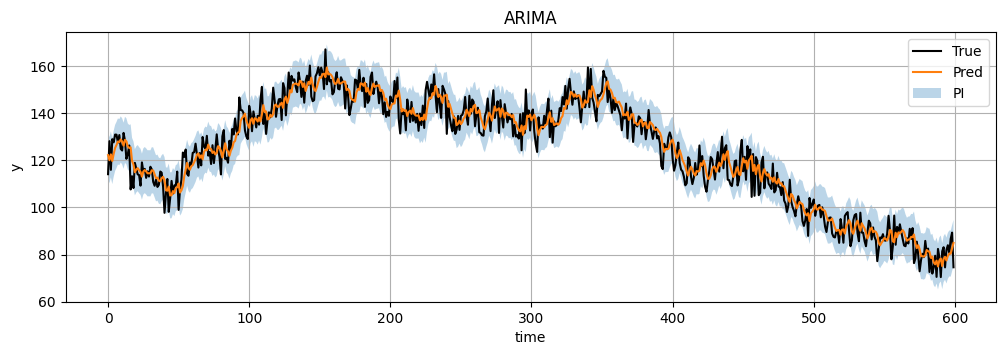

In [6]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= predictions["pred"].to_numpy(),
               PI_low = predictions["lower_bound"].to_numpy(), PI_hi =  predictions["upper_bound"].to_numpy(), conf_PI_low=None, conf_PI_hi=None,
               x_label="time", y_label="y", title='ARIMA')

In [7]:
df_arima

model_name      RMSE   PICP      PIAW     PINAW       CWC
0      ARIMA  5.860662  0.915  19.58261  0.202281  0.792352

## Linear regression

Define metrics

In [8]:
df_linear = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [9]:
predictions = []  # to store different predictions

Quantile estimation

(2998, 3)


Text(0.5, 0, 'time')

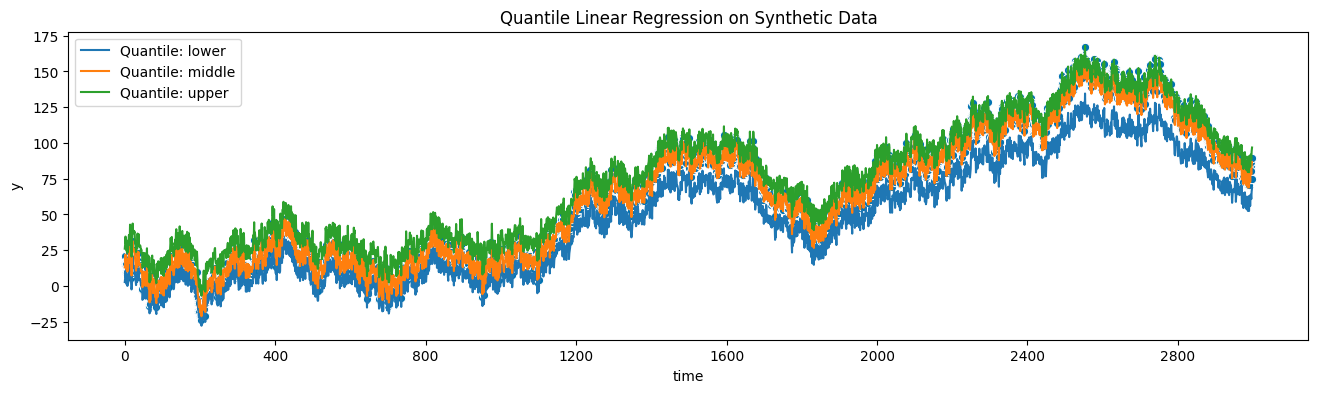

In [10]:
QLR_predictions = {}
        
# fit each prompted quantile and predict on all samples

QLR = QuantileLinearRegressor(quantiles=quantiles.values())
QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
        df_train["y"].to_numpy())

y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
print(y_pred.shape)

QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)


QLR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QLR_predictions)
plt.title("Quantile Linear Regression on Synthetic Data")
plt.xlabel("time")

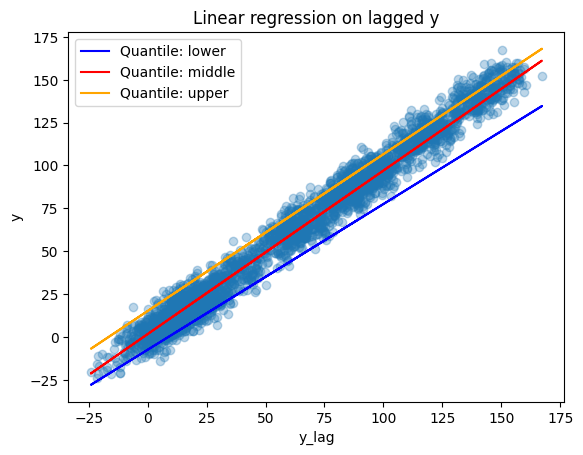

In [11]:
# this cell is to show the correlation between y_lag and y
plt.scatter(df["y_lag"], df["y"], alpha=0.3)
plt.plot(df["y_lag"], QLR_predictions["lower"].flatten(), color="blue",  label="Quantile: lower")

plt.plot(df["y_lag"], QLR_predictions["middle"].flatten(), color="red", label="Quantile: middle")
plt.plot(df["y_lag"], QLR_predictions["upper"].flatten(), color="orange", label="Quantile: upper")


plt.title("Linear regression on lagged y")
plt.xlabel("y_lag")
plt.ylabel("y")
plt.legend()
plt.show()

CQR

  0%|          | 0/600 [00:00<?, ?it/s]

[08:37:24] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=546847;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=376362;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

100%|██████████| 600/600 [01:32<00:00,  6.49it/s]


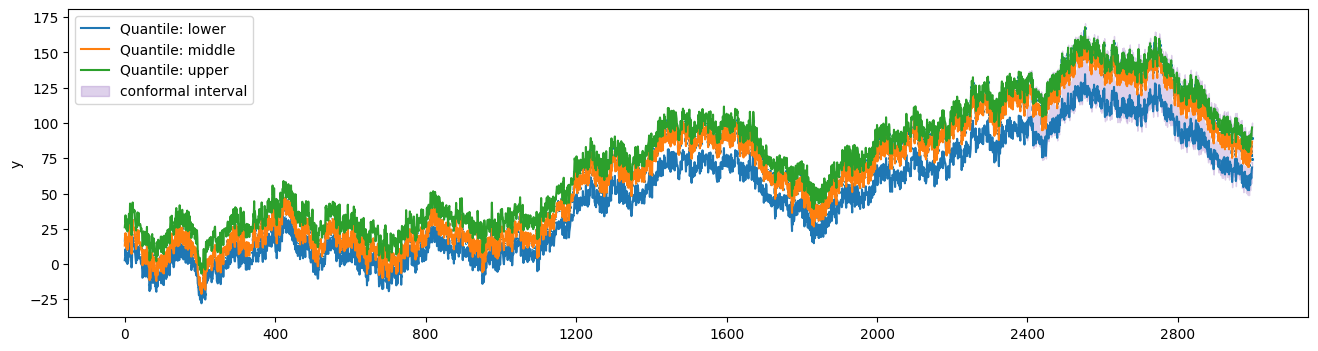

In [12]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[0] = metric.computeAll(model_name="Linear CQR").values()

<Figure size 640x480 with 0 Axes>

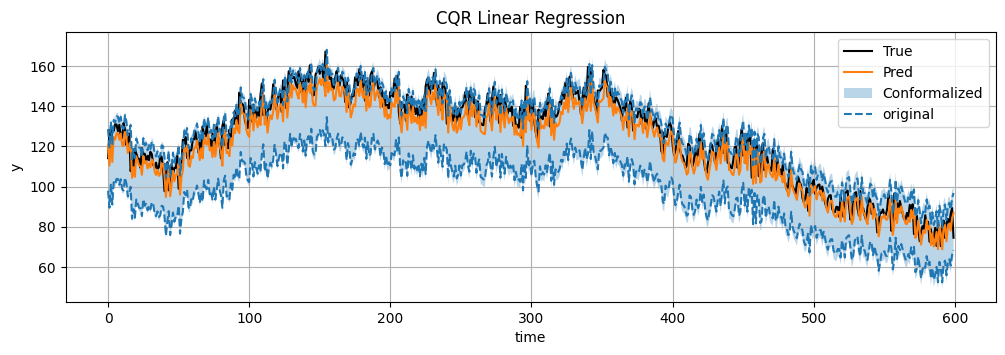

In [13]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Linear Regression')

ACI

100%|██████████| 600/600 [00:04<00:00, 131.52it/s]


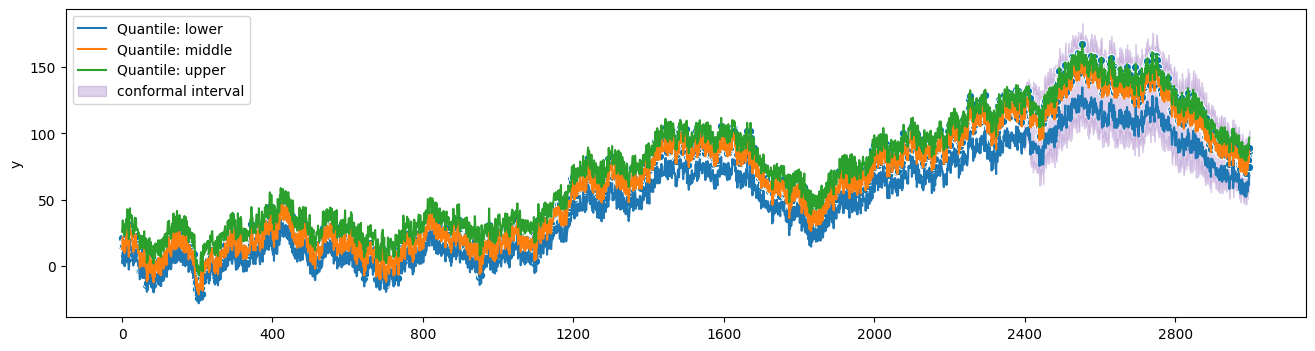

In [14]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[1] = metric.computeAll(model_name="Linear ACI").values()

CQR and ACI plots

<Figure size 640x480 with 0 Axes>

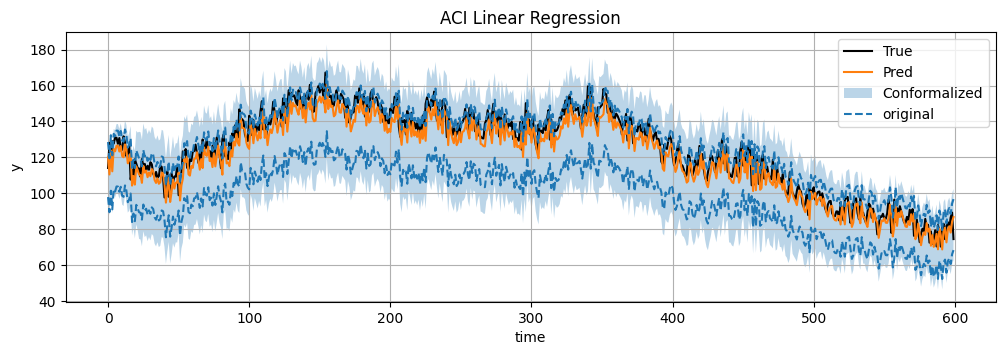

In [15]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Linear Regression')

EnbPI

In [16]:
X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), 
                              df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
X_bootstrap.shape

(2398, 1)

In [17]:
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])
y_bootstrap.shape

(2398,)

In [18]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

batch: 0 batch: 1 batch: 2 batch: 3 batch: 4 batch: 5 batch: 6 batch: 7 batch: 8 batch: 9 batch: 10 batch: 11 batch: 12 batch: 13 batch: 14 batch: 15 batch: 16 batch: 17 batch: 18 batch: 19 

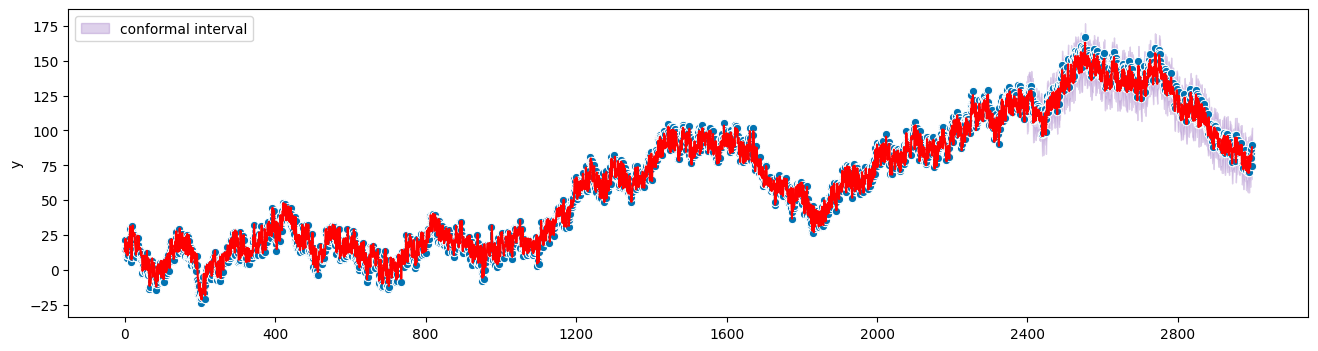

In [19]:
model = QuantileLinearRegressor(quantiles=[0.5])

bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                        bs_train_data=bs_train_data,
                                        X_train=X_bootstrap,
                                        X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"]], conformal_intervals[:,0], conformal_intervals[:,1],)
df_linear.loc[2] = metric.computeAll(model_name="Linear EnbPI").values()

In [20]:
df_linear

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear CQR  8.045551  0.856667  36.973091  0.381919  0.584225
1    Linear ACI  8.045551  0.996667  57.049297  0.589299  0.310298
2  Linear EnbPI  7.437894  0.945000  28.188698  0.291179  0.667042

<Figure size 640x480 with 0 Axes>

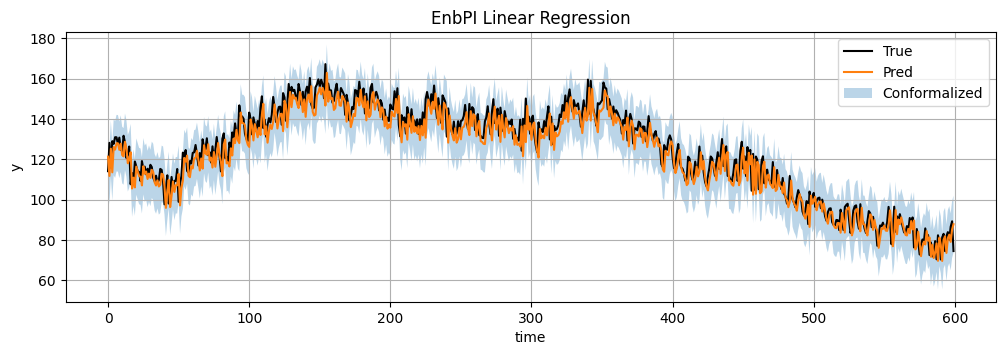

In [21]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Linear Regression')

In [22]:

def local_coverage(y_test, y_lower, y_upper , interval: tuple[int, int]):
    """Compute coverage for a specified interval."""
    l, r = interval
    not_covered = ~((y_test[l:r] >= y_lower[l:r]) & (y_test[l:r] <= y_upper[l:r]))

    return 1 - np.mean(not_covered)


local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (0,200))

0.955

In [23]:
len(df)

2998

In [24]:
# we have a test set of 600 samples, so we use a local window of 20 samples
covs = []
for i in range(10, 600):
    cov = local_coverage(df_test["y"].to_numpy(), conformal_intervals[:,0], conformal_intervals[:,1], (i-10,i))
    covs.append(cov)

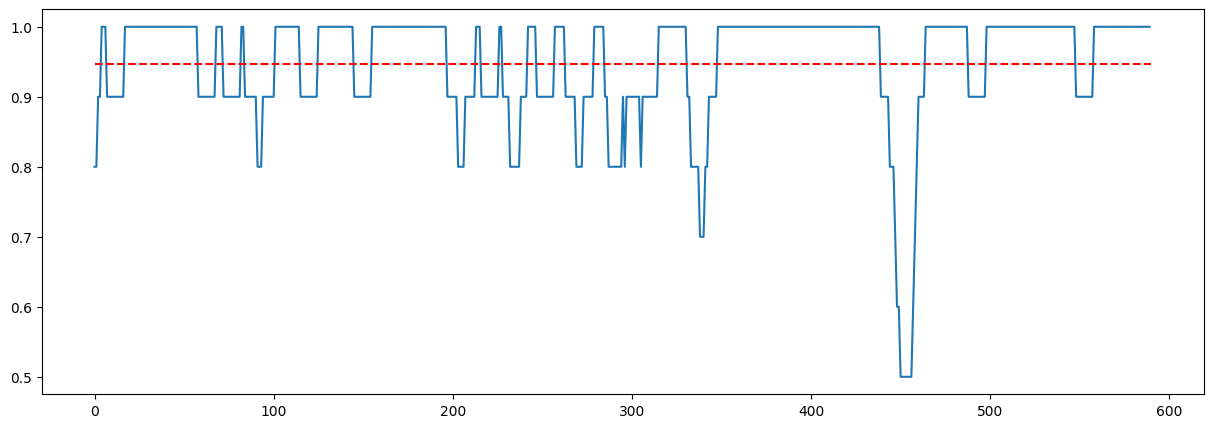

0.9464406779661017


In [25]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(covs)
# create dashed mean plot
ax.plot([0, len(covs)], [np.mean(covs), np.mean(covs)], linestyle="--", color="red")
plt.show()
print(np.mean(covs))

EnCQR

In [26]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [27]:
model = QuantileLinearRegressor(quantiles=[0.05, 0.5, 0.95])
epsilon_low, epsilon_hi = encqr.train(df_train, train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 Training model for Sb: 1 Training model for Sb: 2 

In [28]:
test_label = df_test["y"].to_numpy()

In [29]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2


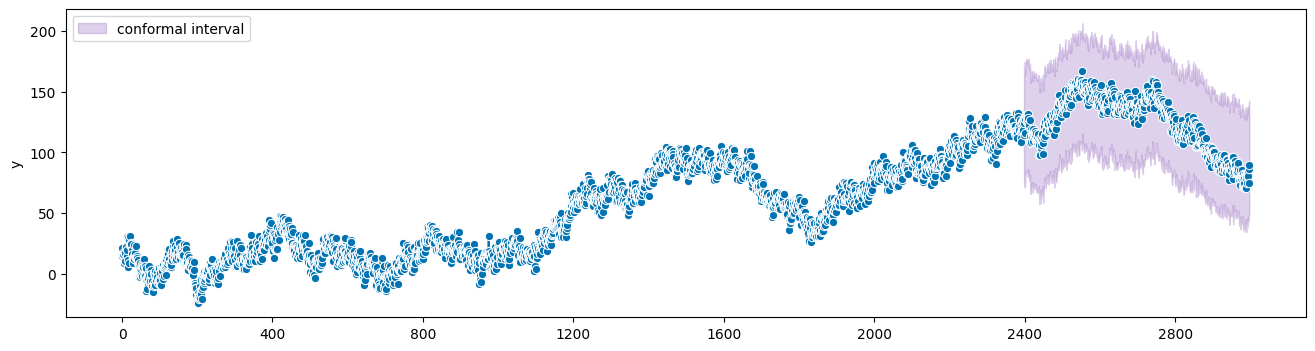

In [30]:

encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_linear.loc[3] = metric.computeAll(model_name="Linear EnCQR").values()

<Figure size 640x480 with 0 Axes>

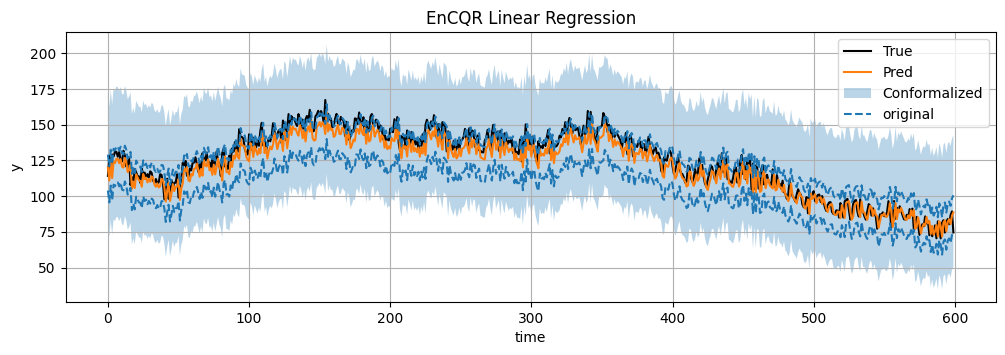

In [31]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Linear Regression')

In [32]:
df_linear

model_name      RMSE      PICP       PIAW     PINAW       CWC
0    Linear CQR  8.045551  0.856667  36.973091  0.381919  0.584225
1    Linear ACI  8.045551  0.996667  57.049297  0.589299  0.310298
2  Linear EnbPI  7.437894  0.945000  28.188698  0.291179  0.667042
3  Linear EnCQR  8.212838  1.000000  91.289444  0.942987  0.042236

Plot testing

In [33]:
def local_cov(y_test, y_lower, y_upper):
    not_covered = ~((y_test >= y_lower) & (y_test <= y_upper))
    
    return 1 - np.mean(not_covered)


local_cov(df_test["y"].to_numpy(), conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten())

1.0

## Quantile Forest

Define metrics

In [34]:
df_forest = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [35]:
predictions = []

Quantile estimation

In [36]:
X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()

In [37]:
QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2)
QFR.fit(X_train, y_train)

In [38]:
y_pred = QFR.predict(X_all)
QFR_predictions = {}

2998it [00:22, 133.53it/s]


In [39]:
y_pred.shape

(2998, 3)

In [40]:
QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)

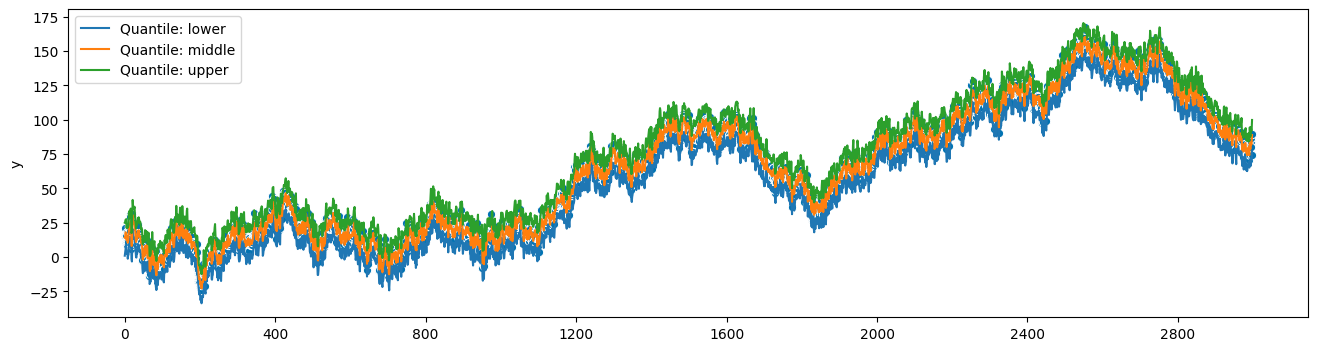

In [41]:
QFR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QFR_predictions)

CQR

100%|██████████| 600/600 [00:01<00:00, 514.81it/s]


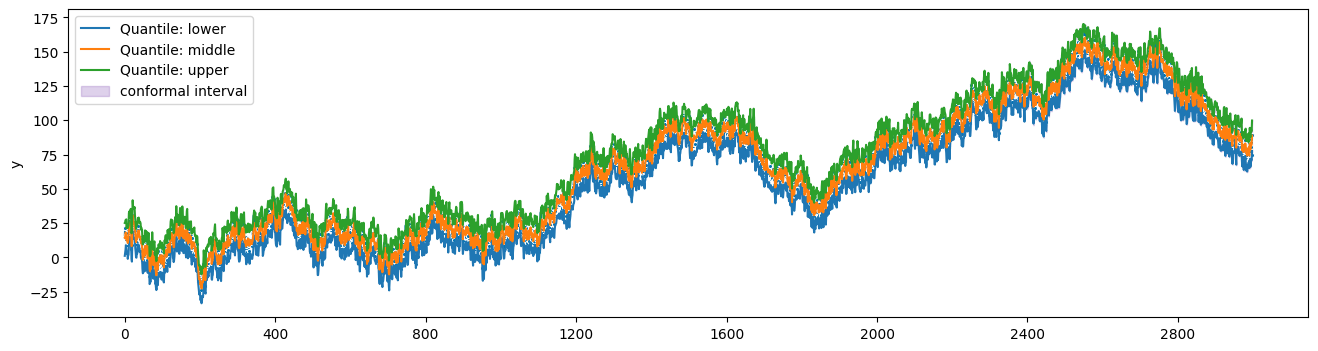

In [42]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[0] = metric.computeAll(model_name="Forest CQR").values()

<Figure size 640x480 with 0 Axes>

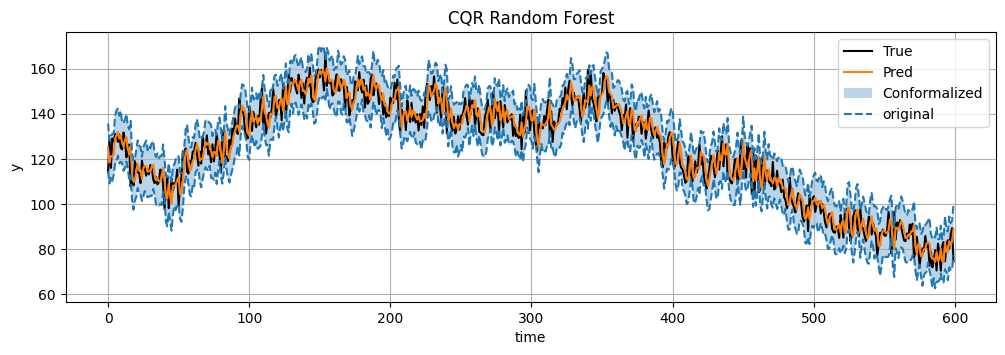

In [43]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Random Forest')

ACI

100%|██████████| 600/600 [00:02<00:00, 220.00it/s]


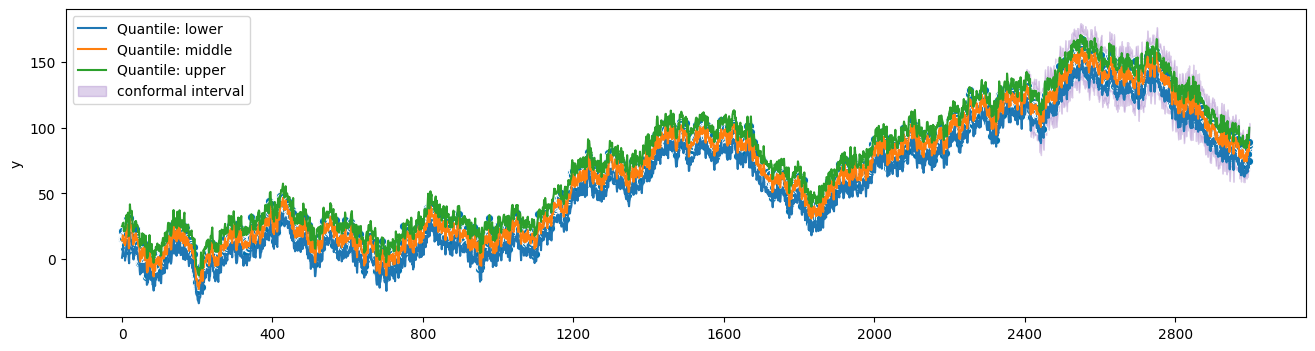

In [44]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[1] = metric.computeAll(model_name="Forest ACI").values()

<Figure size 640x480 with 0 Axes>

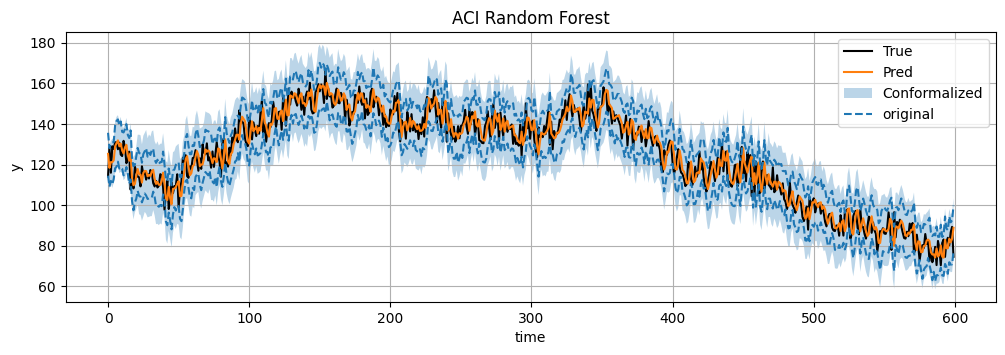

In [45]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Random Forest')

## EnbPI

In [46]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([X_train, X_val], axis=0)
y_bootstrap = np.concatenate([y_train, y_val])

# train data is y_diff_lag and y_diff to predict eventually y
bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [47]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.5], max_depth=2)

# we train on y diff lag and predict on X bootstrap and X test (both diff lag)
bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=X_test)

batch: 0 

2998it [00:19, 150.55it/s]


batch: 1 

2998it [00:21, 141.36it/s]


batch: 2 

2998it [00:19, 152.61it/s]


batch: 3 

2998it [00:19, 151.98it/s]


batch: 4 

2998it [00:19, 152.58it/s]


batch: 5 

2998it [00:20, 149.25it/s]


batch: 6 

2998it [00:20, 149.83it/s]


batch: 7 

2998it [00:19, 153.69it/s]


batch: 8 

2998it [00:19, 150.11it/s]


batch: 9 

2998it [00:19, 151.75it/s]


batch: 10 

2998it [00:19, 154.51it/s]


batch: 11 

2998it [00:20, 149.00it/s]


batch: 12 

2998it [00:21, 139.25it/s]


batch: 13 

2998it [00:19, 152.80it/s]


batch: 14 

2998it [00:19, 150.47it/s]


batch: 15 

2998it [00:19, 152.20it/s]


batch: 16 

2998it [00:19, 156.46it/s]


batch: 17 

2998it [00:19, 151.75it/s]


batch: 18 

2998it [00:19, 152.77it/s]


batch: 19 

2998it [00:19, 154.48it/s]


In [48]:
df_train_val = pd.concat([df_train, df_val], axis=0)

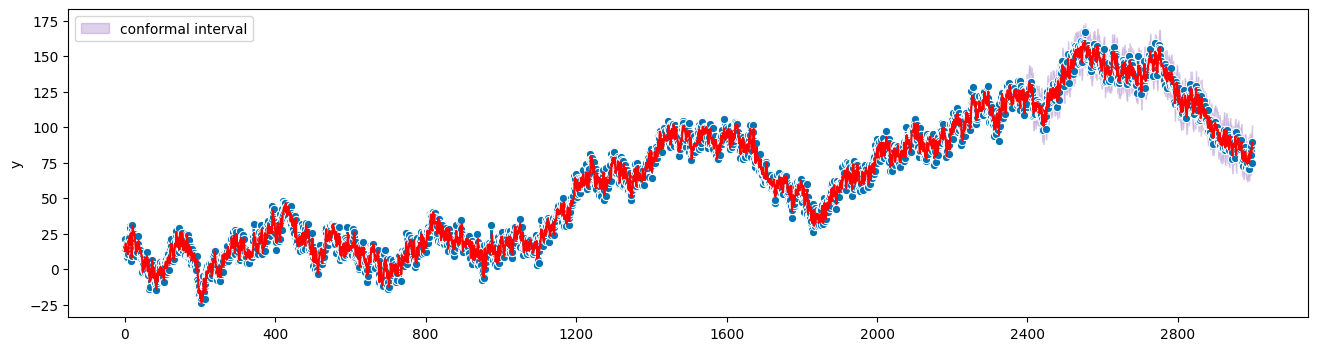

In [49]:

# based on the diff lag predictions and actual
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=df_train_val["y"].to_numpy(),
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_forest.loc[2] = metric.computeAll(model_name="Forest EnbPI").values()

<Figure size 640x480 with 0 Axes>

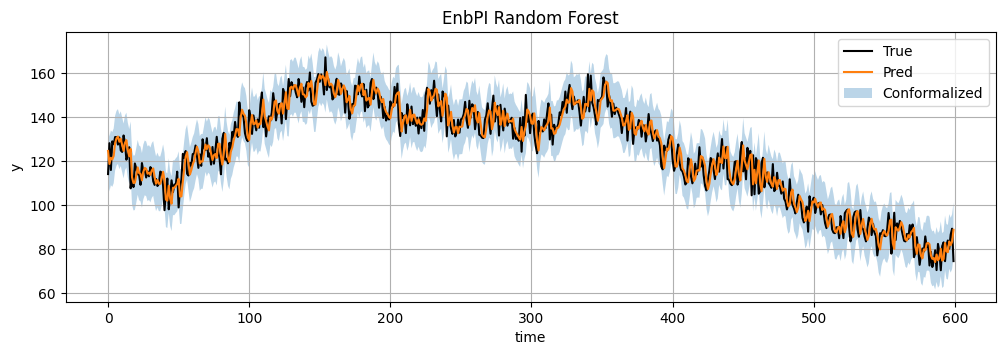

In [50]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Random Forest')

EnCQR

In [51]:
df_train

t          y      y_lag    y_diff  y_diff_lag
0        0  15.042543  11.899683  3.142860    5.073400
1        1  21.174105  15.042543  6.131562    3.142860
2        2  15.639777  21.174105 -5.534328    6.131562
3        3  16.058487  15.639777  0.418709   -5.534328
4        4  10.058106  16.058487 -6.000381    0.418709
...    ...        ...        ...       ...         ...
1793  1793  52.618387  61.657058 -9.038672    6.100988
1794  1794  56.376798  52.618387  3.758412   -9.038672
1795  1795  62.303944  56.376798  5.927145    3.758412
1796  1796  62.646629  62.303944  0.342685    5.927145
1797  1797  60.979271  62.646629 -1.667358    0.342685

[1798 rows x 5 columns]

In [52]:
encqr = EnCQR(n_ensembles=3, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test, differencing=True)


In [53]:
model = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2)

epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Training model for Sb: 0 

799it [00:04, 160.82it/s]
799it [00:05, 156.11it/s]


Training model for Sb: 1 

799it [00:04, 162.42it/s]
799it [00:05, 158.40it/s]


Training model for Sb: 2 

799it [00:05, 156.76it/s]
799it [00:04, 163.93it/s]


In [54]:
test_y.shape

(600,)

In [55]:
test_x.shape

(600, 1)

In [56]:
len(df_train) + len(df_val)

2398

In [57]:
test_label = df_test["y"].to_numpy()

In [58]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label, test_start=2398)

Creating test predictions for Sb 0


600it [00:03, 158.97it/s]


Creating test predictions for Sb 1


600it [00:03, 160.30it/s]


Creating test predictions for Sb 2


600it [00:03, 157.99it/s]


<Figure size 640x480 with 0 Axes>

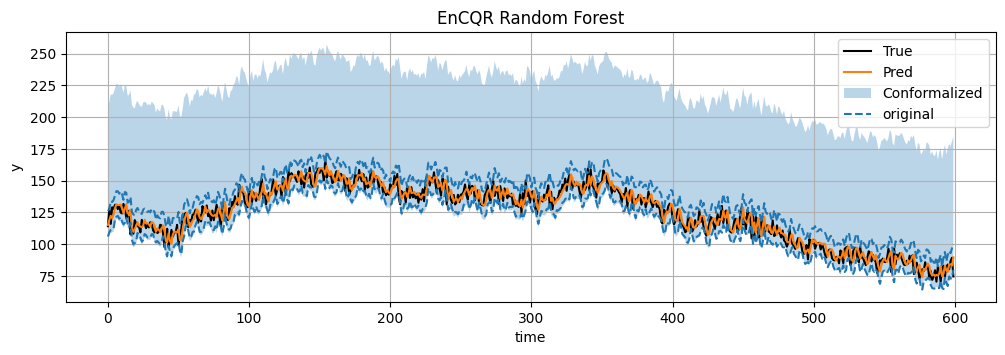

In [59]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Random Forest')

<Figure size 640x480 with 0 Axes>

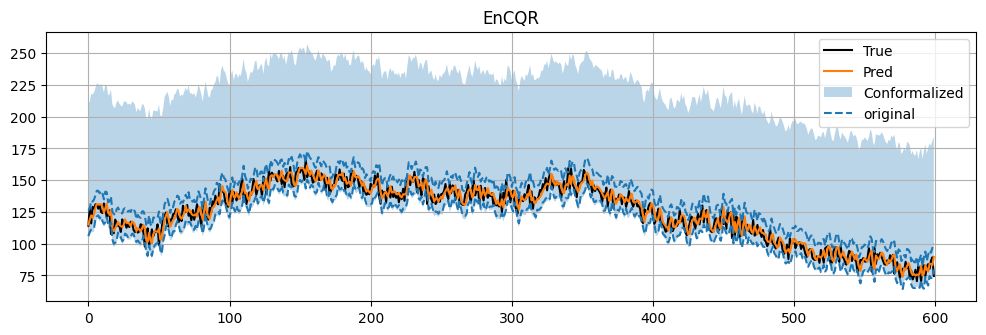

In [60]:
# Plot original and conformalized PI
encqr.plot_PIs(df_test["y"].to_numpy(), PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

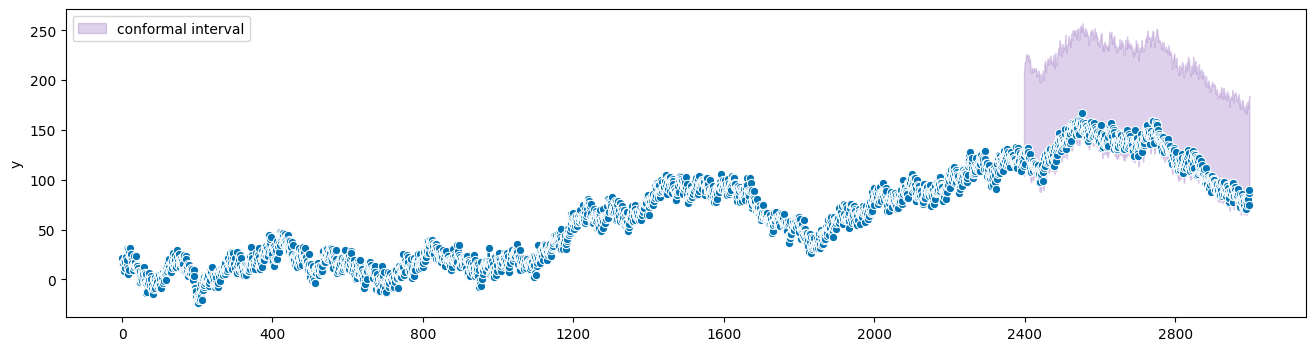

In [61]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_forest.loc[3] = metric.computeAll(model_name="Forest EnCQR").values()

In [62]:
df_forest

model_name      RMSE      PICP        PIAW     PINAW       CWC
0    Forest CQR  6.378337  0.916667   22.239994  0.229731  0.763877
1    Forest ACI  6.378337  0.996667   37.924858  0.391750  0.459552
2  Forest EnbPI  6.345630  0.953333   24.940415  0.257625  0.681653
3  Forest EnCQR  6.423508  0.956667  106.950615  1.104761 -0.095140

## Neural Regression with QRNN

Define metrics

In [5]:
df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [6]:
predictions = []

In [7]:
quantiles

{'lower': 0.05, 'middle': 0.5, 'upper': 0.95}

Quantile estimation

In [8]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)

In [9]:
logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.657        
      2   0.0005         2.788        
      3   0.0005         2.200        
      4   0.0005         1.869        
      5   0.0005         1.763        
      6   0.0005         1.744        
      7   0.0005         1.725        
      8   0.0005         1.696        
      9   0.0005         1.650        
     10   0.0005         1.586        
     11   0.0005         1.495        
     12   0.0005         1.501        
     13   0.0005         1.503        
     14   0.0005         1.458        
     15   0.0005         1.447

In [10]:

y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

NN_predictions = {}
NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)


           WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=662294;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=258307;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

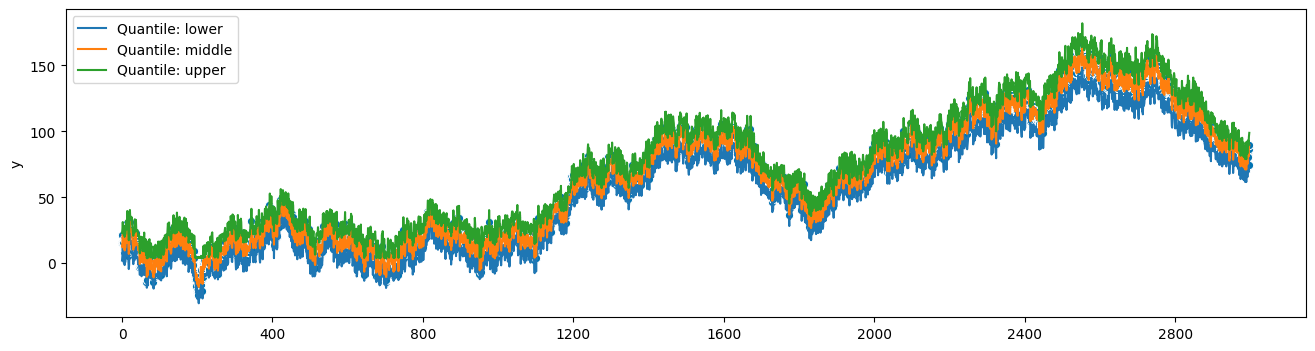

In [11]:
qrnn.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions)

CQR

100%|██████████| 600/600 [01:03<00:00,  9.39it/s]


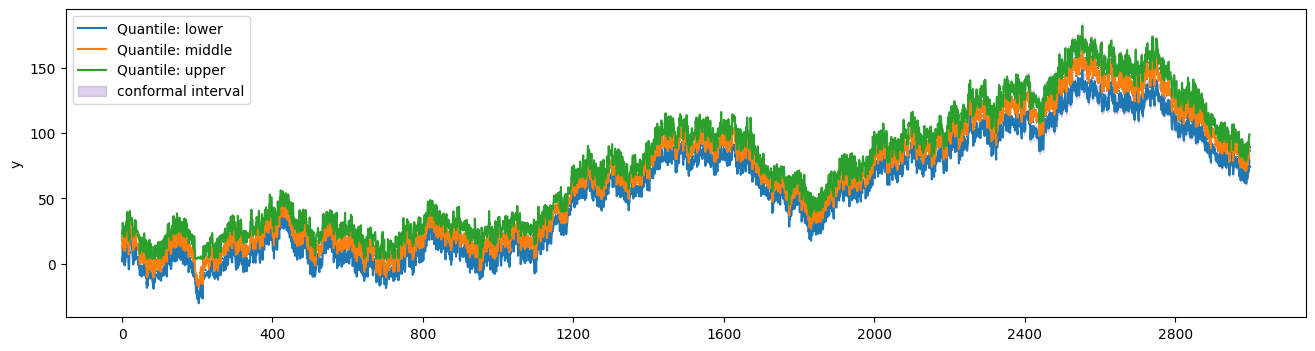

In [12]:
qcr = CQR()
conformal_intervals = qcr.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
qcr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[0] = metric.computeAll(model_name="NN CQR").values()

<Figure size 640x480 with 0 Axes>

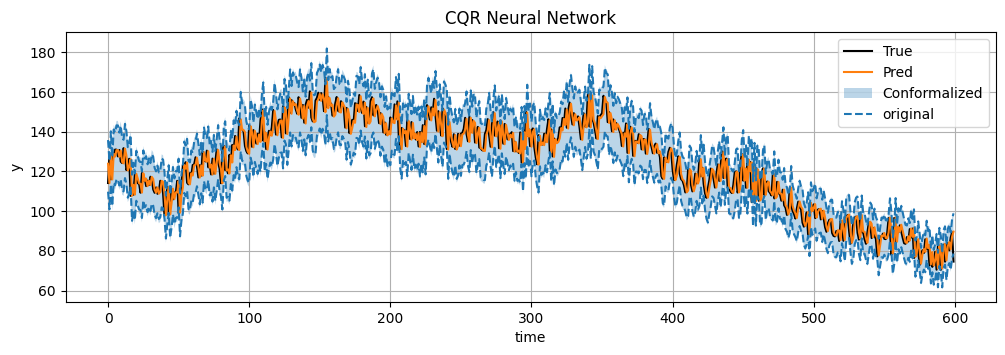

In [14]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR Neural Network')

ACI

100%|██████████| 600/600 [00:02<00:00, 205.35it/s]


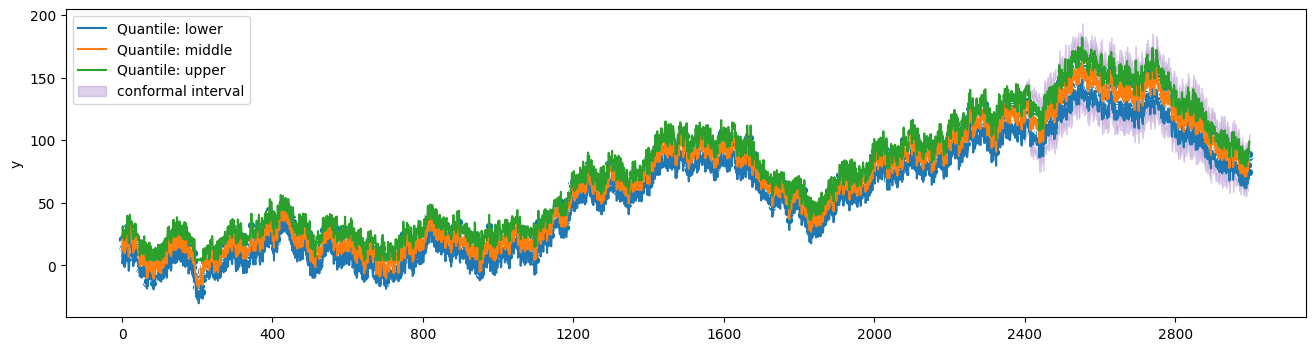

In [15]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split)
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[1] = metric.computeAll(model_name="NN ACI").values()

<Figure size 640x480 with 0 Axes>

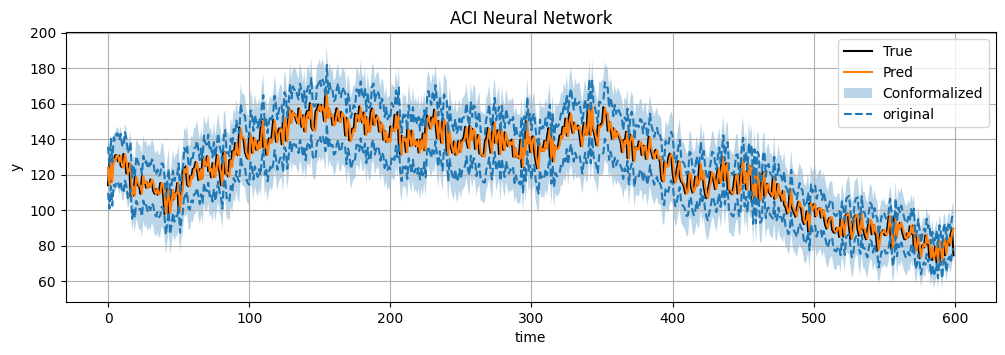

In [16]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Neural Network')

EnbPI

In [17]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.5], n_inputs=1, model_params=model)

In [18]:
n_bs_samples = 20
enbpi = EnbPI(n_bs_samples=n_bs_samples)

X_bootstrap = np.concatenate([df_train["y_lag"].to_numpy().reshape(-1,1), df_val["y_lag"].to_numpy().reshape(-1,1)], axis=0)
y_bootstrap = np.concatenate([df_train["y"].to_numpy(), df_val["y"].to_numpy()])

bs_indices, bs_train_data = enbpi.bootstrap(X_bootstrap, y_bootstrap)

In [19]:
batch = pd.DataFrame({"y_lag" : bs_train_data[0][0][:,0], "y": bs_train_data[0][1].flatten()})

In [20]:
from IPython.utils import io

In [21]:
model = qrnn

# this is to hide the training logs
with io.capture_output() as captured:
    bs_train_preds, bs_test_preds = enbpi.train(model, n_bs_samples=n_bs_samples,
                                            bs_train_data=bs_train_data,
                                            X_train=np.array(X_bootstrap),
                                            X_test=df_test["y_lag"].to_numpy().reshape(-1,1))

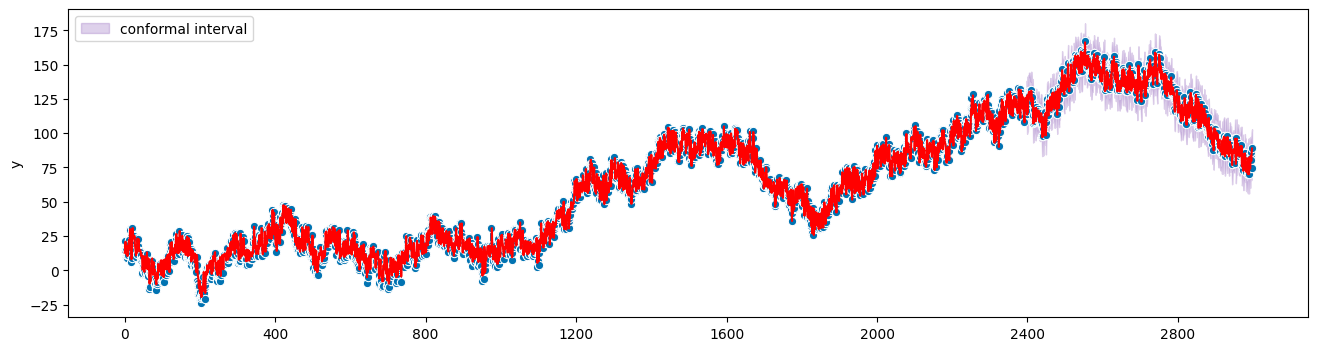

In [22]:
conformal_intervals = enbpi.create_conformal_interval_online(bs_indices=bs_indices,
                            bs_train_preds=bs_train_preds,
                            bs_test_preds=bs_test_preds,
                            y_train=y_bootstrap,
                            y_test=df_test["y"].to_numpy())

preds = np.mean(np.concatenate([bs_train_preds, bs_test_preds], axis=1), axis=0)


enbpi.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], preds, df_test["t"].to_numpy().reshape(-1,1), 
                            conformal_intervals)

metric = Metrics(df_test["y"].to_numpy(), preds[df_test["t"].to_numpy()], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[2] = metric.computeAll(model_name="NN EnbPI").values()

<Figure size 640x480 with 0 Axes>

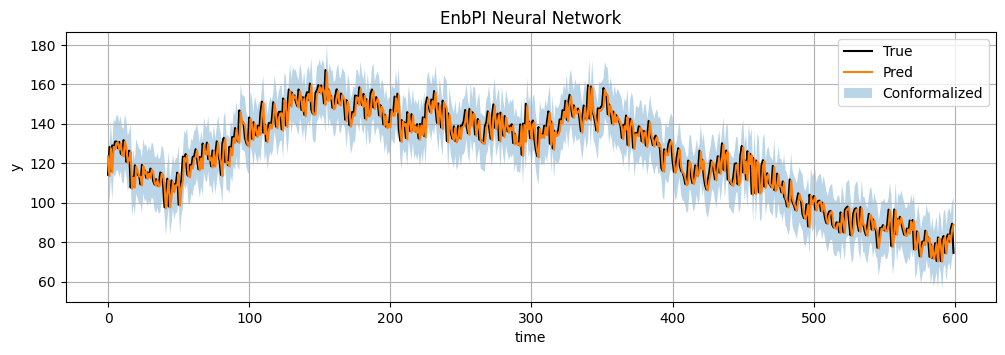

In [23]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= preds[df_test["t"]],
               PI_low = None, PI_hi = None,
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='EnbPI Neural Network')

EnCQR

In [24]:
encqr = EnCQR(n_ensembles=10, alpha=0.1)
train_data, train_label, val_x, val_y, test_x, test_y = encqr.dataloader(df_train, df_val, df_test)


In [25]:
layers = 2
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=[0.05, 0.5, 0.95], n_inputs=1, model_params=model)

In [26]:
model = qrnn
epsilon_low, epsilon_hi = encqr.train(df_train, train_label=train_label, model=model,
                                        train_data=train_data)


Output()

Training model for Sb: 0 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         5.413        
      2   0.0005         5.197        
      3   0.0005         4.677        
      4   0.0005         4.460        
      5   0.0005         4.330        
      6   0.0005         4.313        
      7   0.0005         4.380        
      8   0.0005         3.831        
      9   0.0005         3.584        
     10   0.0005         3.394        
     11   0.0005         3.153        
     12   0.0005         3.453        
     13   0.0005         3.106        
     14   0.0005         3.006        
     15   0.0005         3.085

Output()

Training model for Sb: 1 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         3.983        
      2   0.0005         3.444        
      3   0.0005         3.220        
      4   0.0005         2.893        
      5   0.0005         3.168        
      6   0.0005         2.717        
      7   0.0005         2.282        
      8   0.0005         2.456        
      9   0.0005         2.280        
     10   0.0005         2.204        
     11   0.0005         2.122        
     12   0.0005         1.980        
     13   0.0005         2.041        
     14   0.0005         1.772        
     15   0.0005         1.810

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.804        
      2   0.0005         1.927        
      3   0.0005         1.793        
      4   0.0005         1.760        
      5   0.0005         1.795        
      6   0.0005         1.697        
      7   0.0005         1.771        
      8   0.0005         1.760        
      9   0.0005         1.822        
     10   0.0005         1.728        
     11   0.0005         1.724        
     12   0.0005         1.633        
     13   0.0005         1.725        
     14   0.0005         1.552        
     15   0.0005         1.662

Output()

Training model for Sb: 3 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.591        
      2   0.0005         1.496        
      3   0.0005         1.650        
      4   0.0005         1.587        
      5   0.0005         1.479        
      6   0.0005         1.596        
      7   0.0005         1.525        
      8   0.0005         1.551        
      9   0.0005         1.680        
     10   0.0005         1.480        
     11   0.0005         1.516        
     12   0.0005         1.535        
     13   0.0005         1.614        
     14   0.0005         1.445        
     15   0.0005         1.420

Output()

Training model for Sb: 4 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.587        
      2   0.0005         1.435        
      3   0.0005         1.643        
      4   0.0005         1.575        
      5   0.0005         1.389        
      6   0.0005         1.558        
      7   0.0005         1.450        
      8   0.0005         1.561        
      9   0.0005         1.581        
     10   0.0005         1.537        
     11   0.0005         1.508        
     12   0.0005         1.469        
     13   0.0005         1.612        
     14   0.0005         1.713        
     15   0.0005         1.490

Output()

Training model for Sb: 5 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         2.043        
      2   0.0005         2.001        
      3   0.0005         1.884        
      4   0.0005         1.895        
      5   0.0005         1.813        
      6   0.0005         1.674        
      7   0.0005         1.629        
      8   0.0005         1.503        
      9   0.0005         1.605        
     10   0.0005         1.444        
     11   0.0005         1.608        
     12   0.0005         1.558        
     13   0.0005         1.546        
     14   0.0005         1.541        
     15   0.0005         1.590

Output()

Training model for Sb: 6 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.468        
      2   0.0005         1.444        
      3   0.0005         1.378        
      4   0.0005         1.317        
      5   0.0005         1.373        
      6   0.0005         1.381        
      7   0.0005         1.391        
      8   0.0005         1.368        
      9   0.0005         1.436        
     10   0.0005         1.349        
     11   0.0005         1.507        
     12   0.0005         1.343        
     13   0.0005         1.249        
     14   0.0005         1.385        
     15   0.0005         1.402

Output()

Training model for Sb: 7 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.905        
      2   0.0005         1.554        
      3   0.0005         1.536        
      4   0.0005         1.580        
      5   0.0005         1.539        
      6   0.0005         1.533        
      7   0.0005         1.569        
      8   0.0005         1.622        
      9   0.0005         1.694        
     10   0.0005         1.481        
     11   0.0005         1.622        
     12   0.0005         1.542        
     13   0.0005         1.490        
     14   0.0005         1.494        
     15   0.0005         1.563

Output()

Training model for Sb: 8 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.667        
      2   0.0005         1.561        
      3   0.0005         1.496        
      4   0.0005         1.526        
      5   0.0005         1.692        
      6   0.0005         1.691        
      7   0.0005         1.510        
      8   0.0005         1.497        
      9   0.0005         1.599        
     10   0.0005         1.510        
     11   0.0005         1.587        
     12   0.0005         1.530        
     13   0.0005         1.516        
     14   0.0005         1.552        
     15   0.0005         1.501

Output()

Training model for Sb: 9 

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005         1.741        
      2   0.0005         1.590        
      3   0.0005         1.616        
      4   0.0005         1.568        
      5   0.0005         1.649        
      6   0.0005         1.621        
      7   0.0005         1.553        
      8   0.0005         1.551        
      9   0.0005         1.558        
     10   0.0005         1.477        
     11   0.0005         1.621        
     12   0.0005         1.718        
     13   0.0005         1.522        
     14   0.0005         1.490        
     15   0.0005         1.494

In [27]:
test_label = df_test["y"].to_numpy()

In [28]:
PI, conf_PI = encqr.construct_PI(epsilon_low=epsilon_low, epsilon_hi=epsilon_hi
                   , test_x = test_x,
                   test_y = test_y, test_label=test_label)

Creating test predictions for Sb 0
Creating test predictions for Sb 1
Creating test predictions for Sb 2
Creating test predictions for Sb 3
Creating test predictions for Sb 4
Creating test predictions for Sb 5
Creating test predictions for Sb 6
Creating test predictions for Sb 7
Creating test predictions for Sb 8
Creating test predictions for Sb 9


In [29]:
conf_PI.shape

(600, 1, 3)

In [30]:
# # Plot original and conformalized PI
# encqr.plot_PIs(test_y, PI[:,:,1],
#                PI[:,:,0], PI[:,:,2],
#                conf_PI[:,:,0], conf_PI[:,:,2], title='EnCQR')

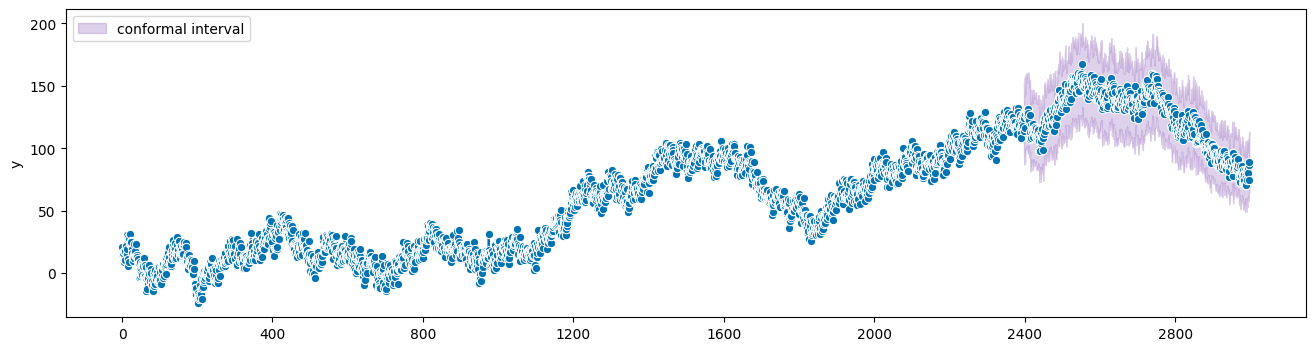

In [31]:
encqr.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], PI, df_test["t"].to_numpy().reshape(-1,1), conf_PI[:,0][:,[0,2]].reshape(-1,2))

preds =  conf_PI[:, :, 1]


metric = Metrics(df_test["y"].to_numpy(), preds, conf_PI[:,:, 0].flatten(), conf_PI[:,:,2].flatten(),)
df_NN.loc[3] = metric.computeAll(model_name="NN EnCQR").values()

<Figure size 640x480 with 0 Axes>

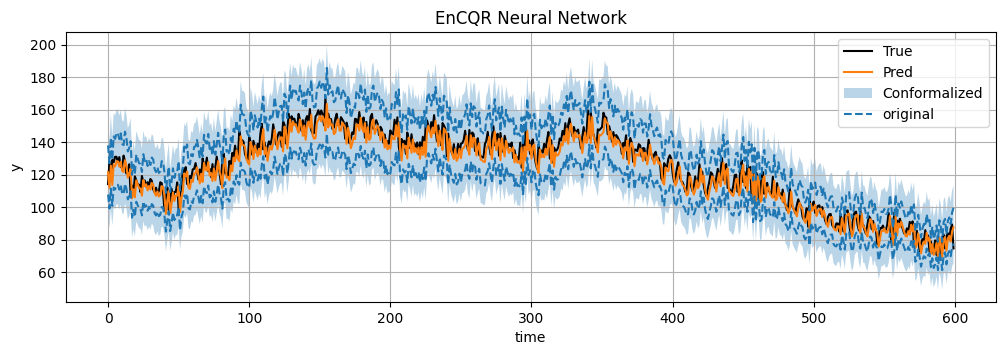

In [32]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= PI[:, :, 1].flatten(),
               PI_low = PI[:, :, 0].flatten(), PI_hi = PI[:, :, 2].flatten(),
               conf_PI_low=conf_PI[:, :, 0].flatten(), conf_PI_hi=conf_PI[:, :, 2].flatten(),
               x_label="time", y_label="y", title='EnCQR Neural Network')

In [33]:
df_NN

model_name      RMSE      PICP       PIAW     PINAW       CWC
0     NN CQR  6.979762  0.951667  29.465593  0.304369  0.642095
1     NN ACI  6.979762  0.998333  47.995018  0.495771  0.377265
2   NN EnbPI  7.023425  0.948333  28.026896  0.289508  0.662403
3   NN EnCQR  7.405481  1.000000  56.835593  0.587091  0.305890

# Comparison

## Tables

In [34]:
df_arima.to_csv(f"{dataset}_arima_300.csv")
df_arima

In [35]:
df_linear.to_csv(f"{dataset}_linear_300.csv")

In [36]:
df_forest.to_csv(f"{dataset}_forest_300.csv")

In [37]:
df_NN.to_csv(f"{dataset}_NN_300.csv")

GRID SEARCH

In [38]:
# scores_lin, gamma_lin = optimize_conformal(model_predictions=QLR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [39]:
# scores_rf, gamma_rf = optimize_conformal(model_predictions=QFR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [40]:
# scores_nn, gamma_nn = optimize_conformal(model_predictions=NN_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)